In [1]:
#!/usr/local/bin/python3
#
# Authors: Harini Mohanasundaram (harmohan), Pradeep Reddy Rokkam (prokkam), Joy Zayatz(jzayatz)
#
# Ice layer finder
# Based on skeleton code by D. Crandall, November 2021
#

In [2]:
from PIL import Image
from numpy import *
from scipy.ndimage import filters
import sys
import imageio

In [3]:
import numpy as np

In [4]:
# calculate "Edge strength map" of an image                                                                                                                                      
def edge_strength(input_image):
    grayscale = array(input_image.convert('L'))
    filtered_y = zeros(grayscale.shape)
    filters.sobel(grayscale,0,filtered_y)
    return sqrt(filtered_y**2)

In [5]:
# draw a "line" on an image (actually just plot the given y-coordinates
#  for each x-coordinate)
# - image is the image to draw on
# - y_coordinates is a list, containing the y-coordinates and length equal to the x dimension size
#   of the image
# - color is a (red, green, blue) color triple (e.g. (255, 0, 0) would be pure red
# - thickness is thickness of line in pixels
#
def draw_boundary(input_image, y_coordinates, color, thickness):
    image = input_image.copy()
    for (x, y) in enumerate(y_coordinates):
        for t in range( int(max(y-int(thickness/2), 0)), int(min(y+int(thickness/2), image.size[1]-1 )) ):
            image.putpixel((x, t), color)
    return image

In [6]:
def draw_asterisk(input_image, pt, color, thickness):
    image = input_image.copy()
    for (x, y) in [ (pt[0]+dx, pt[1]+dy) for dx in range(-3, 4) for dy in range(-2, 3) if dx == 0 or dy == 0 or abs(dx) == abs(dy) ]:
        if 0 <= x < image.size[0] and 0 <= y < image.size[1]:
            image.putpixel((x, y), color)
    return image

In [7]:
# Save an image that superimposes three lines (simple, hmm, feedback) in three different colors 
# (yellow, blue, red) to the filename
def write_output_image(filename, input_image, simple, hmm, feedback, feedback_pt):
    image = input_image.copy()
    new_image = draw_boundary(image, simple, (255, 255, 0), 2)
    new_image = draw_boundary(new_image, hmm, (0, 0, 255), 2)
    new_image = draw_boundary(new_image, feedback, (255, 0, 0), 2)
    new_image = draw_asterisk(new_image, feedback_pt, (255, 0, 0), 2)
    imageio.imwrite(filename, new_image)

In [62]:
input_filename = '31.png'
gt_airice = [ int(i) for i in [25,25] ]
gt_icerock = [ int(i) for i in [55,61] ]

# load in image 
input_image = Image.open(input_filename).convert('RGB')
image_array = array(input_image.convert('L'))



In [63]:
# compute edge strength mask -- in case it's helpful. Feel free to use this.
edge_mask = edge_strength(input_image)
imageio.imwrite('edges.png', uint8(255 * edge_mask / (amax(edge_mask))))

In [64]:
hist, bins = np.histogram(edge_mask, bins = [0,25,50,75,100,150,200,250,400])
print(len(bins))
obs_seq = np.digitize(edge_mask, bins)
obs_seq[:,0]

9


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 3, 6, 7, 5, 4, 6, 5, 4, 5, 3, 3, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       6, 6, 1, 2, 2, 3, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 4, 3, 3, 5,
       4, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1],
      dtype=int64)

In [65]:
e_p_bins = list(range(1,len(bins)+1))
e_p_boundary = np.log([.01,.02,.03,.04,.05,.10,.15,.20,.40])
e_p_not_boundary = np.log([.88,.05,.01,.01,.01,.01,.01,.01,.01])
emission_probs = {'B':dict(zip(e_p_bins, e_p_boundary)),
                  'nB':dict(zip(e_p_bins, e_p_not_boundary))}
emission_probs

{'B': {1: -4.605170185988091,
  2: -3.912023005428146,
  3: -3.506557897319982,
  4: -3.2188758248682006,
  5: -2.995732273553991,
  6: -2.3025850929940455,
  7: -1.8971199848858813,
  8: -1.6094379124341003,
  9: -0.916290731874155},
 'nB': {1: -0.12783337150988489,
  2: -2.995732273553991,
  3: -4.605170185988091,
  4: -4.605170185988091,
  5: -4.605170185988091,
  6: -4.605170185988091,
  7: -4.605170185988091,
  8: -4.605170185988091,
  9: -4.605170185988091}}

In [66]:
def bin_probabilites(hidden_state, observation):
    return emission_probs[hidden_state][observation]

vfunc = np.vectorize(bin_probabilites)

In [67]:
obs_p_b = vfunc('B', obs_seq)
obs_p_notb = vfunc('nB', obs_seq)
       

In [68]:
hidden_states = ['B', 'nB']
initial_p = np.log([.5,.5])
initial_probs = dict(zip(hidden_states, initial_p))
initial_probs

{'B': -0.6931471805599453, 'nB': -0.6931471805599453}

In [69]:
transitions = ['BB', 'BnB', 'nBB', 'nBnB']
trans_p = np.log2([.9,.1,.1,.9])
transition_probs = dict(zip(transitions, trans_p))
transition_probs

{'BB': -0.15200309344504995,
 'BnB': -3.321928094887362,
 'nBB': -3.321928094887362,
 'nBnB': -0.15200309344504995}

In [70]:
# air ice layers

airice_simple = []
for m in range(image_array.shape[1]):
    compare_p = np.subtract(obs_p_b[:,m], obs_p_notb[:,m])
    airice_simple = np.append(airice_simple,argmax(compare_p))
    
airice_hmm = []

B = []
nB = []

#different calculation for first column
e_B = obs_p_b[:,0]
e_nB = obs_p_notb[:,0]

cond_B = initial_probs['B']+ e_B
cond_nB = initial_probs['nB']+ e_nB

B.append(cond_B)
nB.append(cond_nB)

compare = np.subtract(cond_B, cond_nB)
airice_hmm.append(argmax(compare))

#viterbi for remaining columns
for n in range(1, image_array.shape[1]):
  
    obs = obs_seq[:,n]
    e_B = obs_p_b[:,n]
    e_nB = obs_p_notb[:,n]
    previous_B = B[n-1]
    previous_nB = nB[n-1]

    B_from_B = previous_B + transition_probs['BB'] + e_B
    B_from_nB = previous_nB + transition_probs['nBB'] + e_B
    max_B = np.max(list(zip(B_from_B, B_from_nB)), axis = 1)
    B.append(max_B)

    nB_from_B = previous_B + transition_probs['BnB'] + e_nB
    nB_from_nB = previous_nB + transition_probs['nBnB'] + e_nB
    max_nB = np.max(list(zip(nB_from_B, nB_from_nB)), axis = 1)
    nB.append(max_nB)


    compare =np.subtract(max_B, max_nB)
    airice_hmm.append(argmax(compare))


airice_feedback = []

obs_p_b_f= np.roll(obs_p_b, -(gt_airice[1]-1), axis =1)
obs_p_notb_f = np.roll(obs_p_notb, -(gt_airice[1]-1), axis =1)

hidden_states = ['B', 'nB']
initial_p_f = [np.repeat(np.log(.5), 175),np.repeat(np.log(.5), 175)]
initial_probs_f = dict(zip(hidden_states, initial_p_f))
initial_probs_f['B'][gt_airice[0]-1]=np.log(1)
initial_probs_f['nB'][gt_airice[0]-1]=np.log(1e-20)


B = []
nB = []

#different calculation for first column
e_B_f = obs_p_b_f[:,0]
e_nB_f= obs_p_notb_f[:,0]

cond_B = initial_probs_f['B']+ e_B_f
cond_nB = initial_probs_f['nB']+ e_nB_f

B.append(cond_B)
nB.append(cond_nB)

compare = np.subtract(cond_B, cond_nB)
airice_feedback.append(argmax(compare))

#viterbi for remaining columns
for n in range(1, image_array.shape[1]):
  
    obs = obs_seq[:,n]
    e_B_f = obs_p_b_f[:,n]
    e_nB_f = obs_p_notb_f[:,n]
    previous_B = B[n-1]
    previous_nB = nB[n-1]

    B_from_B = previous_B + transition_probs['BB'] + e_B_f
    B_from_nB = previous_nB + transition_probs['nBB'] + e_B_f
    max_B = np.max(list(zip(B_from_B, B_from_nB)), axis = 1)
    B.append(max_B)

    nB_from_B = previous_B + transition_probs['BnB'] + e_nB_f
    nB_from_nB = previous_nB + transition_probs['nBnB'] + e_nB_f
    max_nB = np.max(list(zip(nB_from_B, nB_from_nB)), axis = 1)
    nB.append(max_nB)


    compare =np.subtract(max_B, max_nB)
    airice_feedback.append(argmax(compare))
airice_feedback = np.roll(np.array(airice_feedback), (gt_airice[1]-1))


# ice rock layers
icerock_simple = []
for n in range(image_array.shape[1]):
    try:
        compare_p = np.subtract(obs_p_b[:,n][int(airice_simple[n])+20:],obs_p_notb[:,n][int(airice_simple[n])+20:])
        icerock_simple = np.append(icerock_simple, argmax(compare_p)+20+airice_simple[n])
    except:
        icerock_simple = np.append(icerock_simple, icerock_simple[-1])


        
icerock_hmm = []

B = []
nB = []

#different calculation for first column
e_B = obs_p_b[:,0]
e_nB = obs_p_notb[:,0]

cond_B = initial_probs['B']+ e_B
cond_nB = initial_probs['nB']+ e_nB

B.append(cond_B)
nB.append(cond_nB)

compare = np.subtract(cond_B[int(airice_hmm[0])+20:], cond_nB[int(airice_hmm[0])+20:])

icerock_hmm.append(argmax(compare)+int(airice_hmm[0])+20)
icerock_hmm

#viterbi for remaining columns
for n in range(1, image_array.shape[1]):
  
    obs = obs_seq[:,n]
    e_B = obs_p_b[:,n]
    e_nB = obs_p_notb[:,n]
    previous_B = B[n-1]
    previous_nB = nB[n-1]

    B_from_B = previous_B + transition_probs['BB'] + e_B
    B_from_nB = previous_nB + transition_probs['nBB'] + e_B
    max_B = np.max(list(zip(B_from_B, B_from_nB)), axis = 1)
    B.append(max_B)

    nB_from_B = previous_B + transition_probs['BnB'] + e_nB
    nB_from_nB = previous_nB + transition_probs['nBnB'] + e_nB
    max_nB = np.max(list(zip(nB_from_B, nB_from_nB)), axis = 1)
    nB.append(max_nB)


    compare =np.subtract(max_B[int(airice_hmm[n])+20:], max_nB[int(airice_hmm[n])+20:])
    argmax(compare)
    icerock_hmm.append(argmax(compare)+int(airice_hmm[0])+20)



icerock_feedback = []

obs_p_b_f= np.roll(obs_p_b, -(gt_icerock[1]-1), axis =1)
obs_p_notb_f = np.roll(obs_p_notb, -(gt_icerock[1]-1), axis =1)

hidden_states = ['B', 'nB']
initial_p_f = [np.repeat(np.log(.5), 175),np.repeat(np.log(.5), 175)]
initial_probs_f = dict(zip(hidden_states, initial_p_f))
initial_probs_f['B'][gt_icerock[0]-1]=np.log(1)
initial_probs_f['nB'][gt_icerock[0]-1]=np.log(1e-20)


B = []
nB = []

#different calculation for first column
e_B = obs_p_b_f[:,0]
e_nB = obs_p_notb_f[:,0]

cond_B = initial_probs_f['B']+ e_B_f
cond_nB = initial_probs_f['nB']+ e_nB_f

B.append(cond_B)
nB.append(cond_nB)

compare = np.subtract(cond_B[int(airice_feedback[0])+20:], cond_nB[int(airice_feedback[0])+20:])
icerock_feedback.append(argmax(compare)+int(airice_feedback[0])+20)

#viterbi for remaining columns
for n in range(1, image_array.shape[1]):
  
    obs = obs_seq[:,n]
    e_B_f = obs_p_b_f[:,n]
    e_nB_f = obs_p_notb_f[:,n]
    previous_B = B[n-1]
    previous_nB = nB[n-1]

    B_from_B = previous_B + transition_probs['BB'] + e_B_f
    B_from_nB = previous_nB + transition_probs['nBB'] + e_B_f
    max_B = np.max(list(zip(B_from_B, B_from_nB)), axis = 1)
    B.append(max_B)

    nB_from_B = previous_B + transition_probs['BnB'] + e_nB_f
    nB_from_nB = previous_nB + transition_probs['nBnB'] + e_nB_f
    max_nB = np.max(list(zip(nB_from_B, nB_from_nB)), axis = 1)
    nB.append(max_nB)


    compare =np.subtract(max_B[int(airice_feedback[n])+20:], max_nB[int(airice_feedback[n])+20:])
    icerock_feedback.append(argmax(compare)+int(airice_feedback[n])+20)
icerock_feedback = np.roll(np.array(icerock_feedback), (gt_icerock[1]-1))






# Now write out the results as images and a text file
write_output_image("air_ice_output.png", input_image, airice_simple, airice_hmm, airice_feedback, gt_airice)
write_output_image("ice_rock_output.png", input_image, icerock_simple, icerock_hmm, icerock_feedback, gt_icerock)
with open("layers_output.txt", "w") as fp:
    for i in (airice_simple, airice_hmm, airice_feedback, icerock_simple, icerock_hmm, icerock_feedback):
        fp.write(str(i) + "\n")




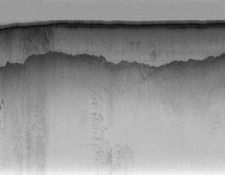

In [71]:
input_image

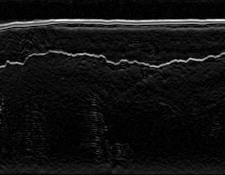

In [72]:
Image.open('edges.png')

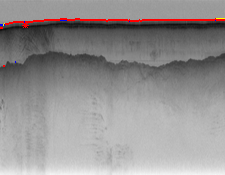

In [73]:
Image.open('air_ice_output.png')

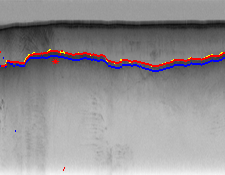

In [74]:
Image.open('ice_rock_output.png')

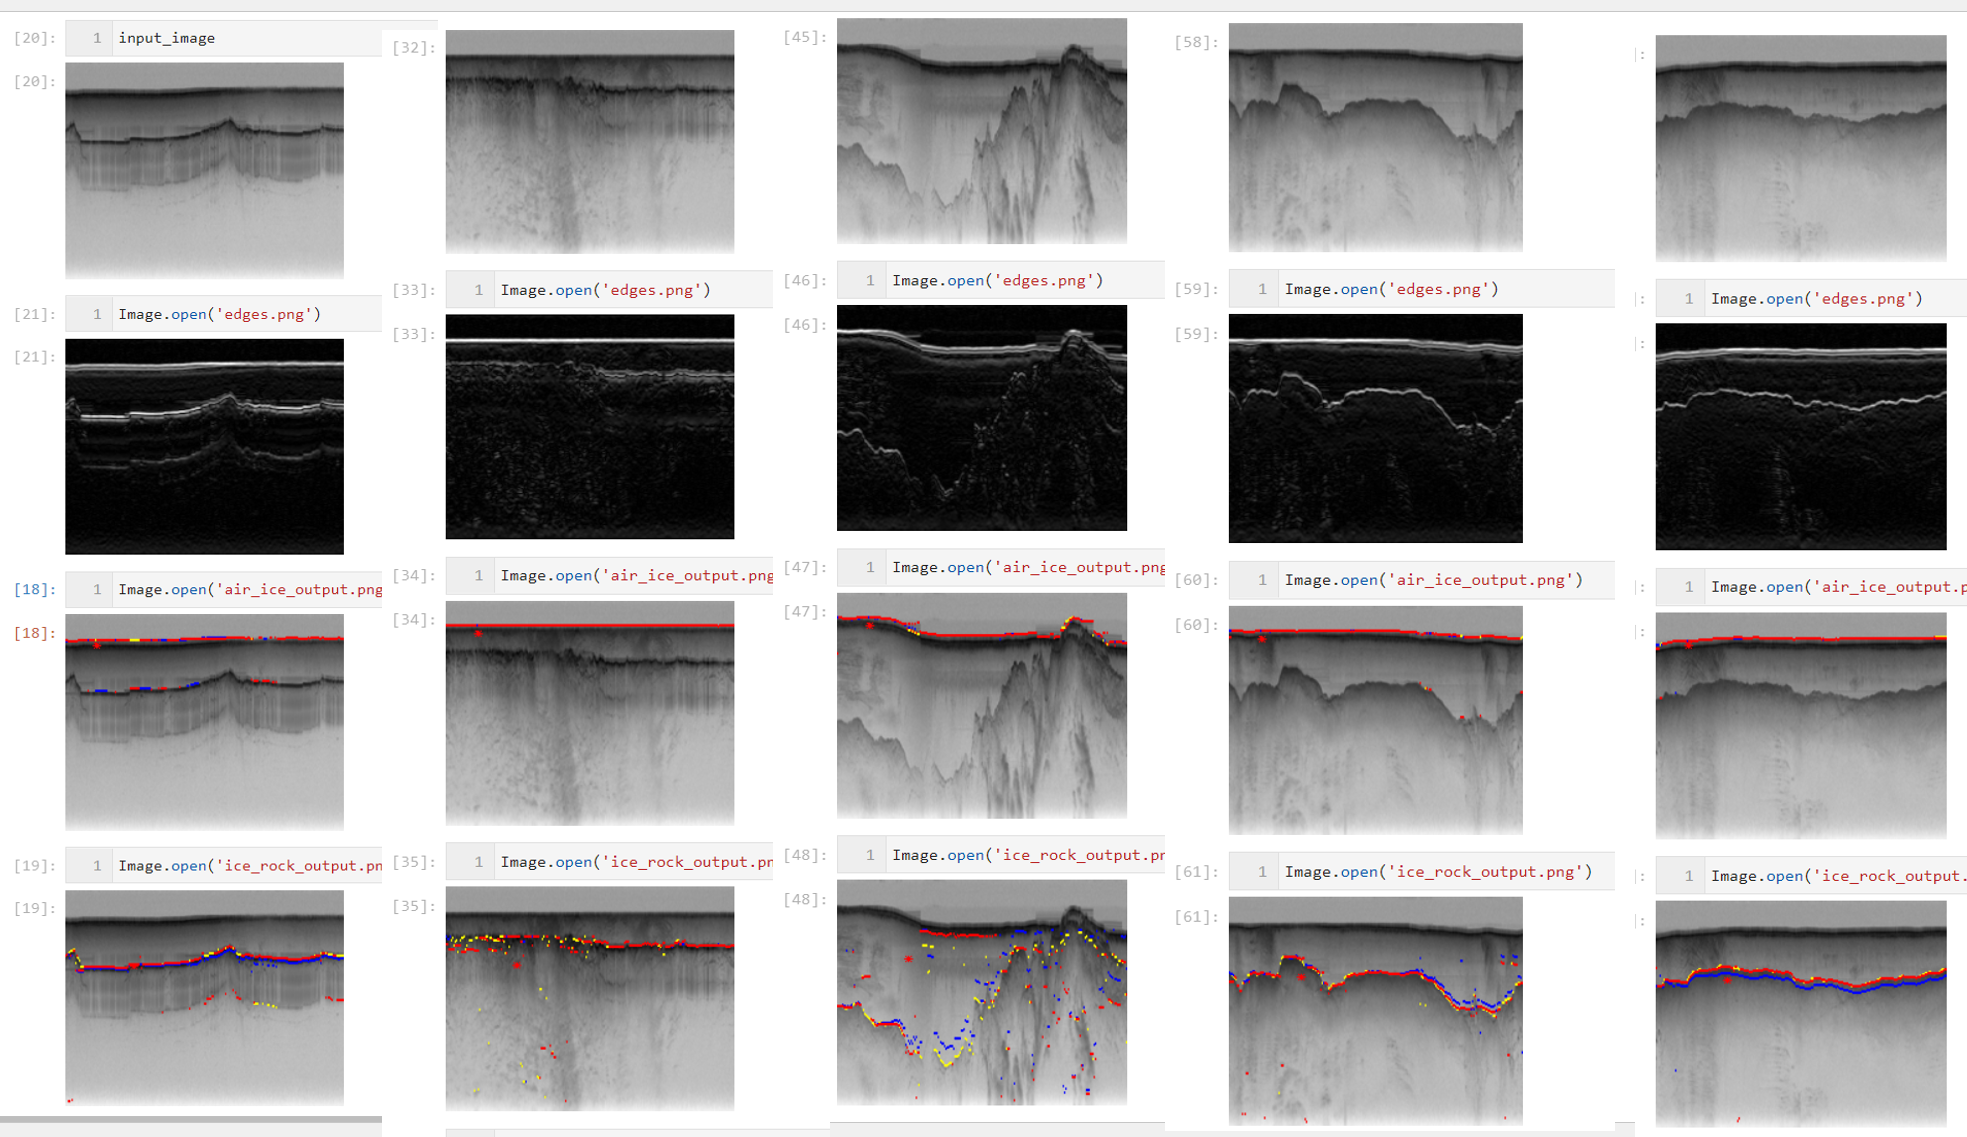

In [75]:
Image.open('collage.png')